In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-12 05:45:39.698629: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-12 05:45:40.846171: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-12 05:45:40.891579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-12 05:45:40.891628: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-12 05:45:40.898728: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-12 05:45:40.898783: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-12 05:45:40.900943: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

refit_gen_GASF_13m_100S5X_15A166006_R12_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.3663356504468719, 1: 0.22525951557093427, 2: 6.4672023374726075, 3: 34.85669291338583, 4: 4.910482529118137, 5: 0.43032954214056574, 6: 18.068571428571428, 7: 2.8259176508139165, 8: 11.852208835341365, 9: 12.611965811965812, 10: 2.7789077212806026, 11: 0.2799203262828417, 12: 7.359600997506234, 13: 38.32727272727273, 14: 2.2073298429319372}
 
Tests 
HEKA test: 6042 train: 24168
fridge/freezer test: 9826 train: 39304
audio system test: 342 train: 1369
breadmaker test: 64 train: 254
broadband router test: 451 train: 1803
computer test: 5143 train: 20574
dehumidifier test: 123 train: 490
dish washer test: 783 train: 3133
electric space heater test: 187 train: 747
food processor test: 175 train: 702
pond pump test: 796 train: 3186
television test:

In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/refit/TL/refit_12_iawe, eco, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data refit training on model iawe seed 12
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.3663356504468719, 1: 0.22525951557093427, 2: 6.4672023374726075, 3: 34.85669291338583, 4: 4.910482529118137, 5: 0.43032954214056574, 6: 18.068571428571428, 7: 2.8259176508139165, 8: 11.852208835341365, 9: 12.611965811965812, 10: 2.7789077212806026, 11: 0.2799203262828417, 12: 7.359600997506234, 13: 38.32727272727273, 14: 2.2073298429319372}
 
Tests 
HEKA test: 6042 train: 24168
fridge/freezer test: 9826 train: 39304
audio system test: 342 train: 1369
breadmaker test: 64 train: 254
broadband router test: 451 train: 1803
computer test: 5143 train: 20574
dehumidifier test: 123 train: 490
dish washer test: 783 train: 3133
electric space heater test: 187 train: 7

2022-02-12 05:45:56.257975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-12 05:45:56.261075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-12 05:45:56.261203: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-12 05:45:56.638060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-12 05:45:56.638096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-12 05:45:56.638102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-12 05:45:56.638653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-12 05:46:04.410167: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-12 05:46:04.428516: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-12 05:46:07.905130: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-12 05:46:08.661396: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-12 05:46:09.554239: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-12 05:46:09.977021: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


4151/4151 - 87s - loss: 1.4902 - accuracy: 0.4755
Epoch 2/50
4151/4151 - 123s - loss: 1.2847 - accuracy: 0.5050
Epoch 3/50
4151/4151 - 120s - loss: 1.2314 - accuracy: 0.5220
Epoch 4/50
4151/4151 - 120s - loss: 1.2144 - accuracy: 0.5318
Epoch 5/50
4151/4151 - 118s - loss: 1.1833 - accuracy: 0.5381
Epoch 6/50
4151/4151 - 120s - loss: 1.1658 - accuracy: 0.5468
Epoch 7/50
4151/4151 - 119s - loss: 1.1517 - accuracy: 0.5514
Epoch 8/50
4151/4151 - 122s - loss: 1.1346 - accuracy: 0.5509
Epoch 9/50
4151/4151 - 120s - loss: 1.1338 - accuracy: 0.5556
Epoch 10/50
4151/4151 - 119s - loss: 1.1233 - accuracy: 0.5539
Epoch 11/50
4151/4151 - 116s - loss: 1.1213 - accuracy: 0.5544
Epoch 12/50
4151/4151 - 117s - loss: 1.1241 - accuracy: 0.5531
Epoch 13/50
4151/4151 - 114s - loss: 1.1160 - accuracy: 0.5588
Epoch 14/50
4151/4151 - 116s - loss: 1.1006 - accuracy: 0.5593
Epoch 15/50
4151/4151 - 115s - loss: 1.1132 - accuracy: 0.5607
Epoch 16/50
4151/4151 - 116s - loss: 1.0977 - accuracy: 0.5630
Epoch 17/50
4

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
4151/4151 - 84s - loss: 1.1815 - accuracy: 0.5402
Epoch 2/50
4151/4151 - 130s - loss: 0.9935 - accuracy: 0.5757
Epoch 3/50
4151/4151 - 133s - loss: 0.9311 - accuracy: 0.5951
Epoch 4/50
4151/4151 - 133s - loss: 0.9115 - accuracy: 0.6054
Epoch 5/50
4151/4151 - 133s - loss: 0.8896 - accuracy: 0.6168
Epoch 6/50
4151/4151 - 134s - loss: 0.8733 - accuracy: 0.6200
Epoch 7/50
4151/4151 - 134s - loss: 0.8566 - accuracy: 0.6244
Epoch 8/50
4151/4151 - 130s - loss: 0.8454 - accuracy: 0.6287
Epoch 9/50
4151/4151 - 135s - loss: 0.8427 - accuracy: 0.6337
Epoch 10/50
4151/4151 - 130s - loss: 0.8418 - accuracy: 0.6293
Epoch 11/50
4151/4151 - 133s - loss: 0.8329 - accuracy: 0.6336
Epoch 12/50
4151/4151 - 130s - loss: 0.8197 - accuracy: 0.6351
Epoch 13/50
4151/4151 - 134s - loss: 0.8167 - accuracy: 0.6350
Epoch 14/50
4151/4151 - 135s - loss: 0.8192 - accuracy: 0.6364
Epoch 15/50
4151/4151 - 132s - loss: 0.8079 - accuracy: 0.6413
Epoch 16/50
4151/4151 - 133s - l

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
4151/4151 - 84s - loss: 1.2905 - accuracy: 0.5124
Epoch 2/50
4151/4151 - 133s - loss: 1.0548 - accuracy: 0.5500
Epoch 3/50
4151/4151 - 132s - loss: 1.0058 - accuracy: 0.5731
Epoch 4/50
4151/4151 - 132s - loss: 0.9894 - accuracy: 0.5869
Epoch 5/50
4151/4151 - 134s - loss: 0.9570 - accuracy: 0.5963
Epoch 6/50
4151/4151 - 133s - loss: 0.9388 - accuracy: 0.6043
Epoch 7/50
4151/4151 - 132s - loss: 0.9406 - accuracy: 0.6009
Epoch 8/50
4151/4151 - 131s - loss: 0.9318 - accuracy: 0.6098
Epoch 9/50
4151/4151 - 130s - loss: 0.9189 - accuracy: 0.6120
Epoch 10/50
4151/4151 - 129s - loss: 0.9029 - accuracy: 0.6147
Epoch 11/50
4151/4151 - 129s - loss: 0.9019 - accuracy: 0.6176
Epoch 12/50
4151/4151 - 129s - loss: 0.9050 - accuracy: 0.6178
Epoch 13/50
4151/4151 - 130s - loss: 0.9049 - accuracy: 0.6176
Epoch 14/50
4151/4151 - 129s - loss: 0.8896 - accuracy: 0.6244
Epoch 15/50
4151/4151 - 130s - loss: 0.8875 - accuracy: 0.6230
Epoch 16/50
4151/4151 - 128s - l

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
4151/4151 - 84s - loss: 1.1285 - accuracy: 0.6082
Epoch 2/50
4151/4151 - 128s - loss: 0.9159 - accuracy: 0.6535
Epoch 3/50
4151/4151 - 128s - loss: 0.8731 - accuracy: 0.6693
Epoch 4/50
4151/4151 - 127s - loss: 0.8413 - accuracy: 0.6775
Epoch 5/50
4151/4151 - 130s - loss: 0.8082 - accuracy: 0.6889
Epoch 6/50
4151/4151 - 129s - loss: 0.8018 - accuracy: 0.6909
Epoch 7/50
4151/4151 - 131s - loss: 0.7911 - accuracy: 0.6958
Epoch 8/50
4151/4151 - 132s - loss: 0.7789 - accuracy: 0.7004
Epoch 9/50
4151/4151 - 125s - loss: 0.7760 - accuracy: 0.7014
Epoch 10/50
4151/4151 - 130s - loss: 0.7632 - accuracy: 0.7060
Epoch 11/50
4151/4151 - 128s - loss: 0.7595 - accuracy: 0.7042
Epoch 12/50
4151/4151 - 129s - loss: 0.7661 - accuracy: 0.7069
Epoch 13/50
4151/4151 - 129s - loss: 0.7451 - accuracy: 0.7126
Epoch 14/50
4151/4151 - 125s - loss: 0.7494 - accuracy: 0.7116
Epoch 15/50
4151/4151 - 130s - loss: 0.7413 - accuracy: 0.7119
Epoch 16/50
4151/4151 - 129s - l

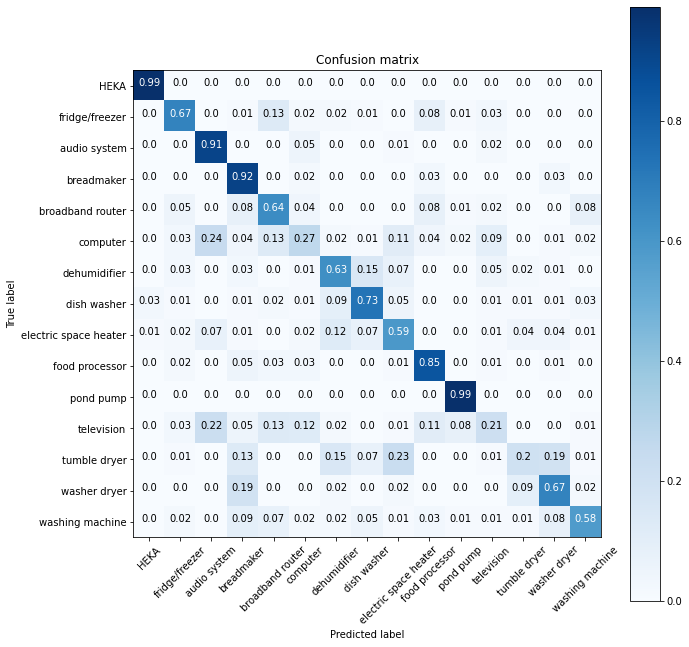

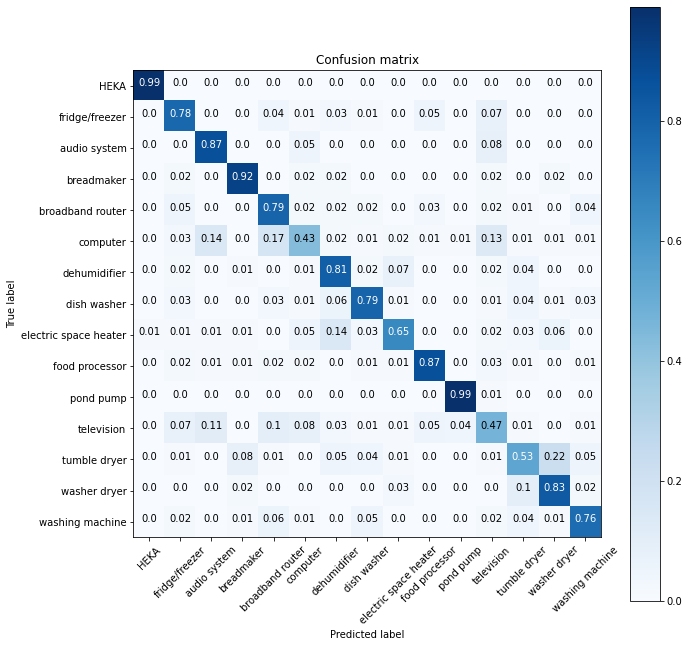

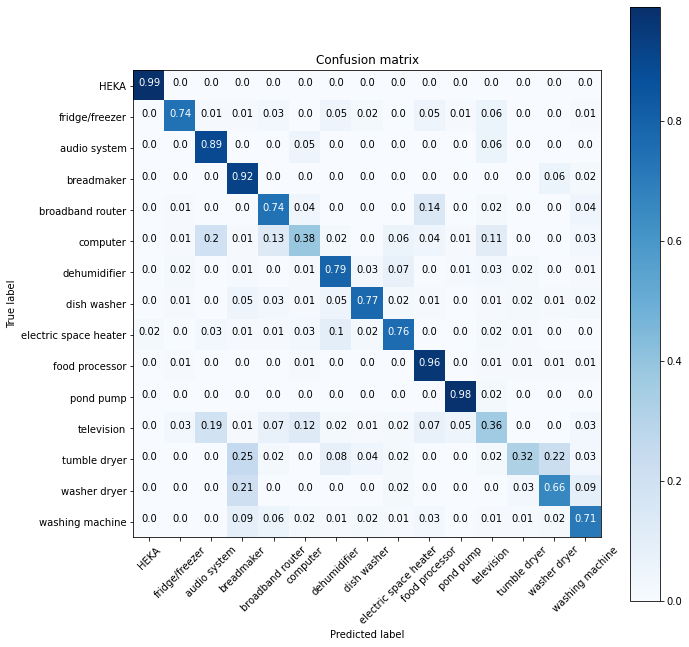

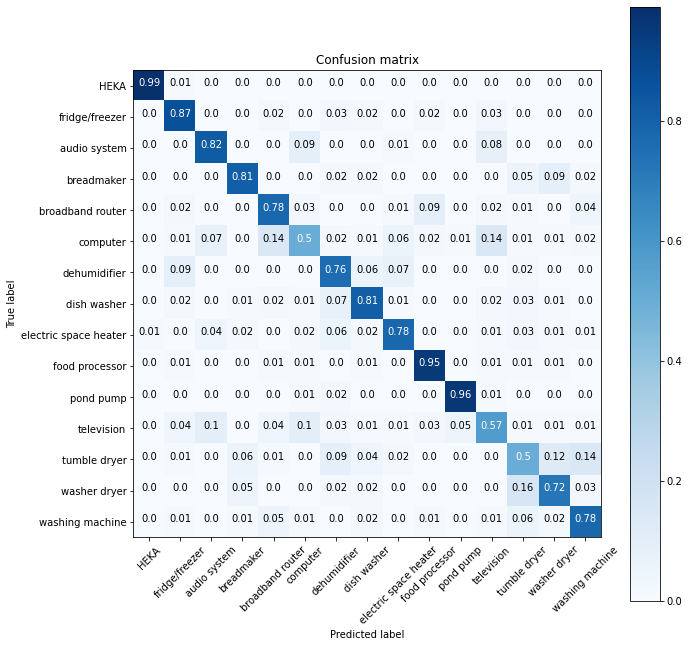

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()